# Extrinsics Calibration - DD24 - Real World scenario

In [1]:
%load_ext autoreload
%autoreload 2



import matplotlib.pyplot as plt

from dt_computer_vision.camera import Pixel

from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners
from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_corners
from dt_computer_vision.camera.calibration.extrinsics.ransac import estimate_homography

In [2]:
import os
import cv2
import numpy as np

from typing import List


from dt_computer_vision.camera import CameraModel
from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6

this_dir: str = os.path.abspath("")
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario0/image-0.png")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

# TODO: update the dimensions of the board once new pattern is finalized
board.square_size = 0.020
board.x_offset = 0.216
board.y_offset = -0.077

# Load camera model from YAML file
yaml_file = os.path.join(
    assets_dir,
    "extrinsics",
    "dd24",
    "real-world",
    "scenario0",
    "calibration-intrinsic-dd24.yaml",
)

with open(yaml_file, "r") as file:
    yaml_content = file.read()
    camera = CameraModel.from_ros_calibration(yaml_content)

print(camera)

assert image.shape == (camera.height, camera.width, 3), f"Image shape: {image.shape}, Camera shape: {*camera.get_shape(), 3}"

CameraModel(width=240, height=320, K=array([[154.58959978,   0.        , 110.33748015],
       [  0.        , 154.94617019, 161.1407896 ],
       [  0.        ,   0.        ,   1.        ]]), D=array([-0.35435176,  0.16442206,  0.00194067, -0.00289178, -0.04067351]), P=array([[154.58959978,   0.        , 110.33748015,   0.        ],
       [  0.        , 154.94617019, 161.1407896 ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]]), R=array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]]), H=None, rectifier=<dt_computer_vision.camera.types.Rectifier object at 0x7e2c13b670a0>)


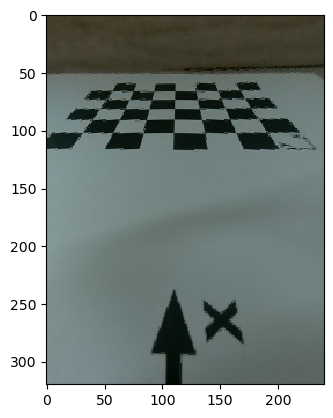

In [3]:
# rectify image
image = camera.rectifier.rectify(image)
rectified = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rectified)

In [4]:
# find corners
corners: List[Pixel] = find_corners(image, board)
print(f"Found {len(corners)} corners.")
assert len(corners) == (board.columns - 1) * (board.rows - 1)

Found 35 corners.


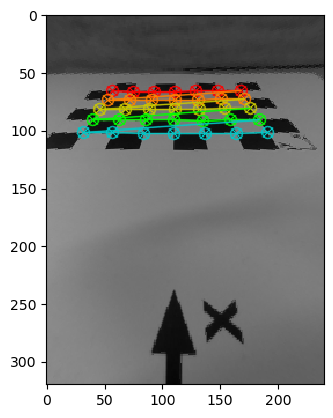

In [5]:
# draw detected corners on top of the image
image_w_corners = draw_corners(image, board, corners)
image_w_corners_rgb = cv2.cvtColor(image_w_corners, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_corners_rgb)

In [6]:
# estimate homography
H = estimate_homography(corners, board, camera)

In [8]:
print(H.flatten().tolist())

[0.005453421128060058, 0.044599781197580186, 0.17557654548449209, -0.07867737362730311, 0.0003581087851342888, 0.0020481805070481675, 0.02350974507608566, 0.8687761415465534, 1.0]


# Ground Reprojection

In [9]:
from typing import List
from dt_computer_vision.camera.calibration.extrinsics.chessboard import get_ground_corners_and_error, compute_placement_error

from dt_computer_vision.camera import NormalizedImagePoint
from dt_computer_vision.ground_projection import GroundPoint

image_corners: List[NormalizedImagePoint]
ground_corners: List[GroundPoint]
ground_corners_projected: List[GroundPoint]
errors: List[float]

image_corners, ground_corners, ground_corners_projected, errors = get_ground_corners_and_error(camera, corners, board, H)

for i, (image_corner, ground_corner, ground_corner_projected, error) in enumerate(zip(image_corners, ground_corners, ground_corners_projected, errors)):
    # print out (image point, ground computed, and ground oracle) points
    print(f"{i}\t: I[{image_corner}] -> Gc[{ground_corner_projected}] ~ G[{ground_corner}]: {float(error):.4f}m")

# compute average error
avg_error = np.average(errors)
std_error = np.std(errors)
print(f"Overall error: {avg_error:.4f}m +/- {std_error:.4f}m")

# find all corners that are on the X and Y axis of the calibration pattern (the lines partitioning the board into 4 equal quadrants)
placement_error: float = compute_placement_error(corners, board, errors)
print(f"Placement error: {placement_error:.4f}m")

0	: I[P(-0.3454, -0.6113)] -> Gc[P(0.3178, 0.0629)] ~ G[P(0.316, 0.063)]: 0.0018m
1	: I[P(-0.2276, -0.6102)] -> Gc[P(0.3167, 0.0425)] ~ G[P(0.316, 0.043)]: 0.0009m
2	: I[P(-0.1133, -0.6095)] -> Gc[P(0.3159, 0.023)] ~ G[P(0.316, 0.023)]: 0.0001m
3	: I[P(0.0046, -0.6107)] -> Gc[P(0.316, 0.0031)] ~ G[P(0.316, 0.003)]: 0.0001m
4	: I[P(0.1206, -0.6131)] -> Gc[P(0.3167, -0.0163)] ~ G[P(0.316, -0.017)]: 0.0010m
5	: I[P(0.2446, -0.6125)] -> Gc[P(0.3159, -0.0368)] ~ G[P(0.316, -0.037)]: 0.0003m
6	: I[P(0.3714, -0.6133)] -> Gc[P(0.3157, -0.0576)] ~ G[P(0.316, -0.057)]: 0.0006m
7	: I[P(-0.3741, -0.5638)] -> Gc[P(0.296, 0.0624)] ~ G[P(0.296, 0.063)]: 0.0006m
8	: I[P(-0.2489, -0.563)] -> Gc[P(0.2953, 0.0424)] ~ G[P(0.296, 0.043)]: 0.0009m
9	: I[P(-0.1245, -0.5633)] -> Gc[P(0.295, 0.0229)] ~ G[P(0.296, 0.023)]: 0.0010m
10	: I[P(0.0032, -0.5654)] -> Gc[P(0.2955, 0.0031)] ~ G[P(0.296, 0.003)]: 0.0005m
11	: I[P(0.1309, -0.5641)] -> Gc[P(0.2946, -0.0165)] ~ G[P(0.296, -0.017)]: 0.0015m
12	: I[P(0.261, -